In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
model = 'random_waypoint'
method = 'median'

df_eval = pd.concat([
    pd.read_csv(f'evaluate/evaluate_{model}_{i}.csv')
    for i in range(3, 19)
])

In [51]:
df_eval.columns

Index(['velocity', 'towers', 'users', 'accuracy', 'accuracy_std', 'error',
       'error_std', 'recover_time', 'map_time', 'execution_time'],
      dtype='object')

In [52]:
len(df_eval)

2016

In [53]:
df_eval = getattr(df_eval.groupby(['velocity', 'towers', 'users']), method)().reset_index()

In [54]:
df_eval[df_eval.users == 512].accuracy.min()

0.07368977864583334

In [49]:
df_eval[df_eval.users == 512].accuracy.min()

0.08106282552083333

In [17]:
df_eval.velocity.unique()

array(['(0.01, 0.01)', '(0.01, 0.02)', '(0.02, 0.04)', '(0.04, 0.04)',
       '(0.04, 0.08)', '(0.08, 0.1)', '(0.1, 0.1)'], dtype=object)

# Accuracy and error analysis

In [23]:
def plot_heatmap(vel_restriction, metric='accuracy', ax=None, vmin=None, vmax=None, cbar=True, title=''):
    df = df_eval[df_eval.velocity == vel_restriction]
    
    n_tower_values = len(df.towers.unique())
    n_users_values = len(df.users.unique())

    sns.heatmap(
        df[metric].as_matrix().reshape((n_tower_values, n_users_values)),
        ax=ax,
        xticklabels=df['users'].unique(),
        yticklabels=df['towers'].unique(),
        vmax=vmax,
        vmin=vmin,
        cbar=cbar,
        square=True,
        fmt=".2f",
        annot=True,
    )
    
    ax.set(xlabel='# Users', ylabel='# Towers')
#     ax.set_title(title, pad=12)

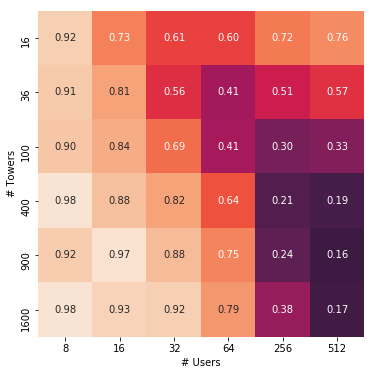

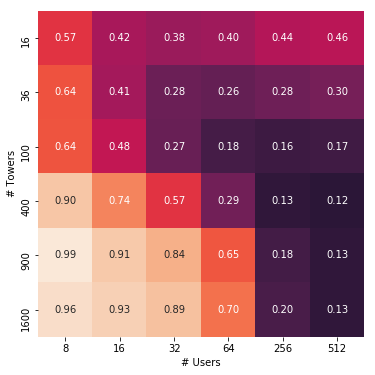

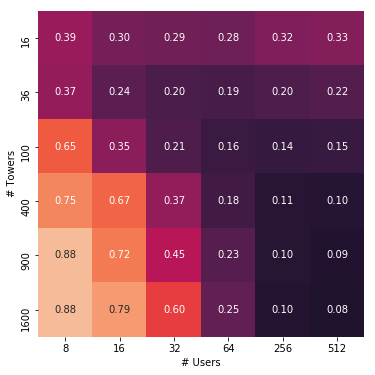

In [24]:
velocities = ['(0.01, 0.01)', '(0.04, 0.04)', '(0.1, 0.1)']
# velocities = ['(0.01, 0.02)', '(0.02, 0.04)', '(0.04, 0.08)', '(0.08, 0.1)']
n_velocity_values = len(velocities)

for i, vel in enumerate(velocities):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    plot_heatmap(
        vel_restriction=vel,
        title=f'Velocity {vel}',
        metric='accuracy',
        ax=axes,
        vmin=0,
        vmax=1,
        cbar=False)

    plt.savefig(f'./accuracy_{model}_{vel}.png', dpi=300)

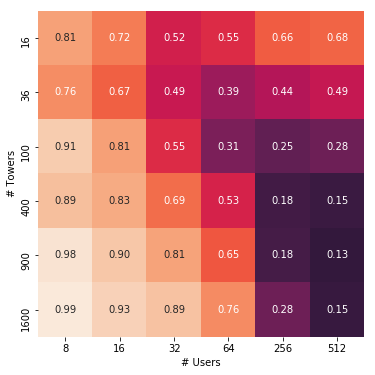

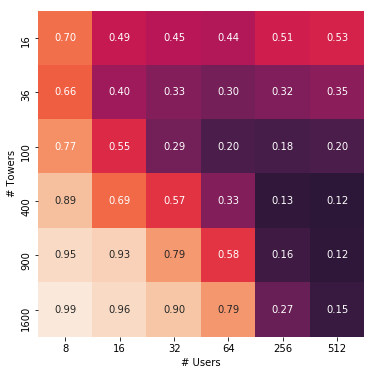

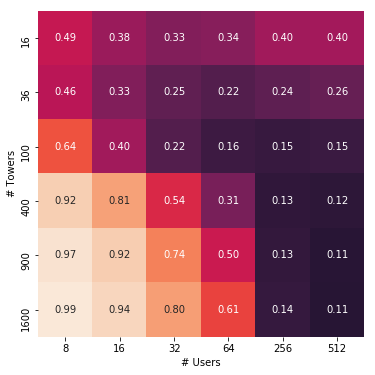

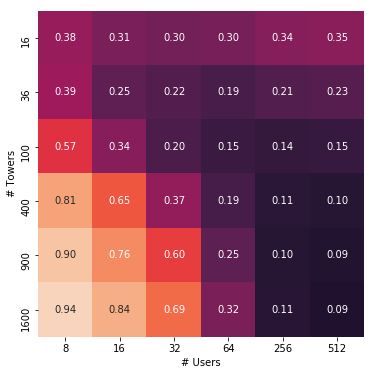

In [25]:
# velocities = ['(0.01, 0.01)', '(0.04, 0.04)', '(0.1, 0.1)']
velocities = ['(0.01, 0.02)', '(0.02, 0.04)', '(0.04, 0.08)', '(0.08, 0.1)']
n_velocity_values = len(velocities)

for i, vel in enumerate(velocities):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    plot_heatmap(
        vel_restriction=vel,
        title=f'Velocity {vel}',
        metric='accuracy',
        ax=axes,
        vmin=0,
        vmax=1,
        cbar=False)

    plt.savefig(f'./accuracy_{model}_{vel}.png', dpi=300)

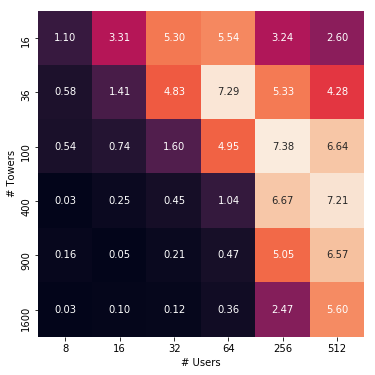

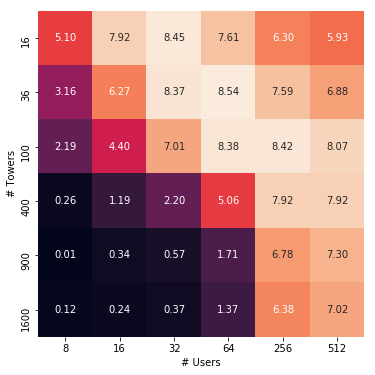

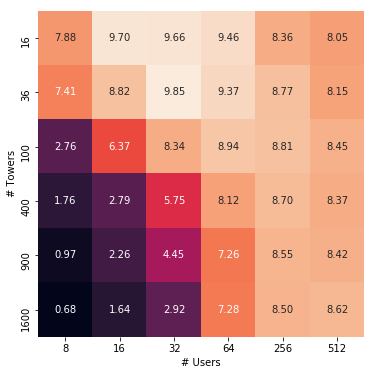

In [26]:
velocities = ['(0.01, 0.01)', '(0.04, 0.04)', '(0.1, 0.1)']
# velocities = ['(0.01, 0.02)', '(0.02, 0.04)', '(0.04, 0.08)', '(0.08, 0.1)']
n_velocity_values = len(velocities)

for i, vel in enumerate(velocities):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    plot_heatmap(vel_restriction=vel, metric='error', ax=axes, title=f'Velocity {vel}', cbar=False)

    plt.savefig(f'./error_{model}_{vel}.png', dpi=300)

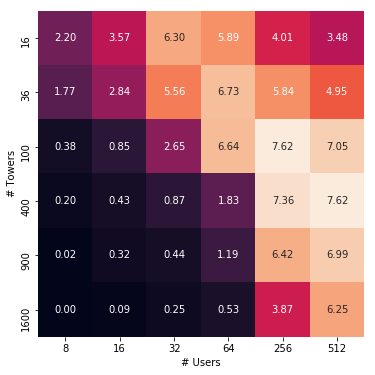

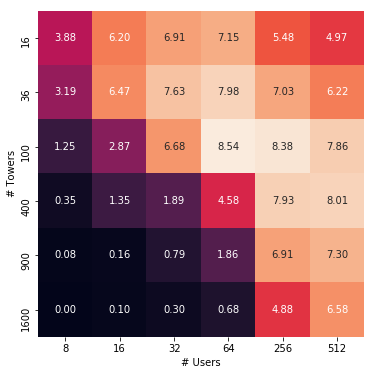

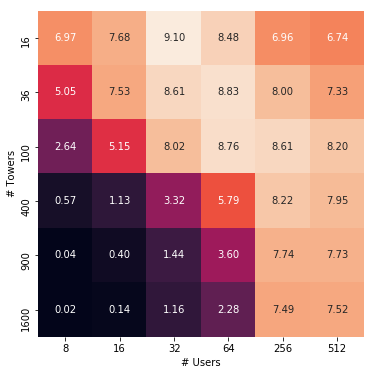

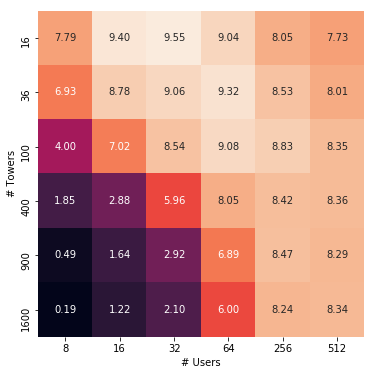

In [27]:
# velocities = ['(0.01, 0.01)', '(0.04, 0.04)', '(0.1, 0.1)']
velocities = ['(0.01, 0.02)', '(0.02, 0.04)', '(0.04, 0.08)', '(0.08, 0.1)']
n_velocity_values = len(velocities)

for i, vel in enumerate(velocities):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    plot_heatmap(vel_restriction=vel, metric='error', ax=axes, title=f'Velocity {vel}', cbar=False)

    plt.savefig(f'./error_{model}_{vel}.png', dpi=300)

# Execution time analysis

In [ ]:
ax = df_eval[
#     (df_eval.velocity == '(0.1, 0.1)') &
#     (df_eval.towers == 1600)
    (df_eval.velocity == 0.005) &
    (df_eval.towers == 900)
].set_index('users')[['recover_time', 'map_time', 'execution_time']].plot.line()

ax.set_xlabel("# Users")
ax.set_ylabel("Time (s)")

plt.savefig(f'./execution_time.png', dpi=300)